In [1]:
import json
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shutil

import torch
import torchvision
import torch.nn as nn

import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from ultralytics import YOLO

from transformers import SwinModel, SwinConfig
from transformers import AutoImageProcessor
from transformers import DefaultDataCollator
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

from datasets import load_dataset

In [2]:
if torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


In [3]:
def load_dataframe_heads(root_dir):
    # Load annotations JSON file
    with open(os.path.join(root_dir, 'annotations.json')) as file:
        data = json.load(file)

    # Extract data from the JSON file
    create_dict = lambda i: {'id': i['id'], 'image_id': i['image_id'], 'identity': i['identity'], 'position': i['position']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])
    create_dict = lambda i: {'file_name': i['path'].split('/')[-1], 'image_id': i['id'], 'date': i['date']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    # Merge the information from the JSON file
    df = pd.merge(df_annotation, df_images, on='image_id')
    df['path'] = 'images' + os.path.sep + df['identity'] + os.path.sep + df['file_name']
    df = df.drop(['image_id', 'file_name'], axis=1)
    df['date'] = df['date'].apply(lambda x: x[:4] + '-' + x[5:7] + '-' + x[8:])

    return df

def load_dataframe_full(root_dir):
    # Load annotations JSON file
    with open(os.path.join(root_dir, 'annotations.json')) as file:
        data = json.load(file)

    # Extract data from the JSON file
    create_dict = lambda i: {'id': i['id'], 'bbox': i['bbox'], 'image_id': i['image_id'], 'identity': i['identity'], 'segmentation': i['segmentation'], 'position': i['position']}
    df_annotation = pd.DataFrame([create_dict(i) for i in data['annotations']])
    create_dict = lambda i: {'file_name': i['path'].split('/')[-1], 'image_id': i['id'], 'date': i['date']}
    df_images = pd.DataFrame([create_dict(i) for i in data['images']])

    # Merge the information from the JSON file
    df = pd.merge(df_annotation, df_images, on='image_id')
    df['path'] = 'images' + os.path.sep + df['identity'] + os.path.sep + df['file_name']
    df = df.drop(['image_id', 'file_name'], axis=1)
    df['date'] = df['date'].apply(lambda x: x[:4] + '-' + x[5:7] + '-' + x[8:])

    return df

def load_dataframe(root_dir, img_type='heads'):
    if img_type == 'heads':
        return load_dataframe_heads(root_dir)
    elif img_type == 'full':
        return load_dataframe_full(root_dir)
    else:
        raise(Exception('Choose img_type from (heads, full).'))

def get_image(path: str) -> Image:
    '''
    Loads and image and converts it into PIL.Image.
    We load it with OpenCV because PIL does not apply metadata.
    '''
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def plot_grid(
        df: pd.DataFrame,
        root: str,
        n_rows: int = 5,
        n_cols: int = 8,
        offset: float = 10,
        img_min: float = 100,
        rotate: bool = True
        ) -> Image:
    """Plots a grid of size (n_rows, n_cols) with images from the dataframe.

    Args:
        df (pd.DataFrame): Dataframe with column `path` (relative path).
        root (str): Root folder where the images are stored.
        n_rows (int, optional): The number of rows in the grid.
        n_cols (int, optional): The number of columns in the grid.
        offset (float, optional): The offset between images.
        img_min (float, optional): The minimal size of the plotted images.
        rotate (bool, optional): Rotates the images to have the same orientation.

    Returns:
        The plotted grid.
    """

    # Select indices of images to be plotted
    n = min(len(df), n_rows*n_cols)
    idx = np.random.permutation(len(df))[:n]

    # Load images and compute their ratio
    ratios = []
    for k in idx:
        file_path = os.path.join(root, df.iloc[k]['path'])
        im = get_image(file_path)
        ratios.append(im.size[0] / im.size[1])

    # Get the size of the images after being resized
    ratio = np.median(ratios)
    if ratio > 1:
        img_w, img_h = int(img_min*ratio), int(img_min)
    else:
        img_w, img_h = int(img_min), int(img_min/ratio)

    # Create an empty image grid
    im_grid = Image.new('RGB', (n_cols*img_w + (n_cols-1)*offset, n_rows*img_h + (n_rows-1)*offset))

    # Fill the grid image by image
    for k in range(n):
        i = k // n_cols
        j = k % n_cols

        # Load the image
        file_path = os.path.join(root, df.iloc[idx[k]]['path'])
        im = get_image(file_path)

        # Possibly rotate the image
        if rotate and ((ratio > 1 and im.size[0] < im.size[1]) or (ratio < 1 and im.size[0] > im.size[1])):
            im = im.transpose(Image.ROTATE_90)

        # Rescale the image
        im.thumbnail((img_w,img_h))

        # Place the image on the grid
        pos_x = j*img_w + j*offset
        pos_y = i*img_h + i*offset
        im_grid.paste(im, (pos_x,pos_y))
    return im_grid

In [4]:
root_dir = '/home/yusuf/python/SeaTurtle'
df = load_dataframe(root_dir, img_type='heads')
df.sort_values(by=['date'])

,id,identity,position,date,path
3096,3172,t001,topright,2010-07-02,images/t001/VMyJozldvy.jpg
3093,3169,t001,topleft,2010-07-02 14:07:16,images/t001/ZkWKNtWbVK.JPG
3098,3174,t001,topleft,2010-07-02 14:07:24,images/t001/kTIpheVAuj.JPG
3094,3170,t001,top,2010-07-02 14:08:14,images/t001/ZKnMahXQgJ.JPG
3095,3171,t001,top,2010-07-02 14:08:52,images/t001/dLFculJDGP.JPG
...,...,...,...,...,...
6764,6933,t125,left,2021-09-14 17:45:25,images/t125/HDrANMLOYr.jpeg
6759,6928,t125,left,2021-09-14 17:45:33,images/t125/hEubZnMiWl.jpeg
6762,6931,t125,topleft,2021-09-14 17:46:34,images/t125/VdKeqPKYci.jpeg
6758,6927,t125,left,2021-09-14 17:46:34,images/t125/dKFQMAqieM.jpeg


In [5]:
# Need to create a time aware split - For each turtle lets split like this - all but 2 years in training data, then keep 1 year for test
# and one more for validation

In [6]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'],  format='mixed')

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# all images from 2010 - 2018 go to the train set
train_year_mask = (df['year'] >= 2010) & (df['year'] <= 2018)
val_year_mask = (df['year'] == 2019)
test_year_mask = (df['year'] >= 2020) & (df['year'] <= 2022)

train_set = df[train_year_mask]
val_set = df[val_year_mask]
test_set = df[test_year_mask]


In [7]:
def organize_dataset(df, root_dir, destination_dir):
    for _, row in df.iterrows():
        file_path = row['path']  # Assuming 'path' column has the relative path
        category = row['identity']  # Assuming 'identity' column has the category
        dest_category_dir = os.path.join(destination_dir, category)

        # Create category directory in the destination if it doesn't exist
        os.makedirs(dest_category_dir, exist_ok=True)

        # Define the source and destination paths for the file
        src_file_path = os.path.join(root_dir, file_path)
        dest_file_path = os.path.join(dest_category_dir, os.path.basename(file_path))

        # Copy the file
        shutil.copy(src_file_path, dest_file_path)

root_dir = '/home/yusuf/python/SeaTurtle'
organize_dataset(train_set, root_dir, '/home/yusuf/python/SeaTurtle/data/train')
organize_dataset(test_set, root_dir, '/home/yusuf/python/SeaTurtle/data/test')
organize_dataset(val_set, root_dir, '/home/yusuf/python/SeaTurtle/data/val')

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Training a vision transformer from hugging face

In [9]:
dataset = load_dataset("imagefolder", data_dir='./data')

Resolving data files:   0%|          | 0/5183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1087 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1314 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [10]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=191x214>,
 'label': 0}

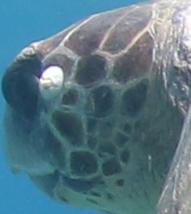

In [11]:
dataset['train'][0]['image']

In [12]:
transf = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     #transforms.RandomPerspective(distortion_scale=0.6, p=0.4),
     #transforms.RandomRotation(degrees=(-15, 15)),
     #transforms.RandomAffine(degrees=(-15, 15)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

def transform(data):
    data['image'] = [transf(image) for image in data['image']]
    data['pixel_values'] = data.pop('image')
    return data    

dataset.set_transform(transform)


data_collator = DefaultDataCollator()

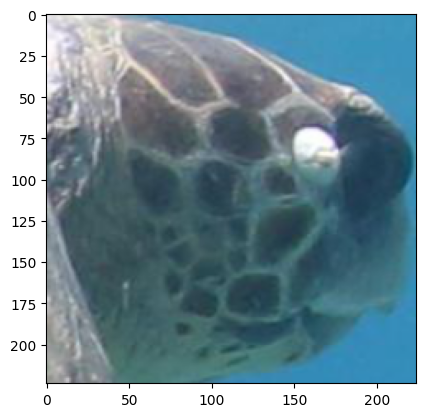

(None, 0)

In [13]:
imshow(dataset['train'][0]['pixel_values']), dataset['train'][0]['label']

In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [15]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [16]:
import evaluate

accuracy = evaluate.load("accuracy")

In [17]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [18]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./model_results/ViT4",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=500,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,5.975800,5.990709,0.002762
2,5.712500,5.953803,0.002762


In [ ]:
trainer.predict(dataset["test"])

In [ ]:
trainer.evaluate(dataset["test"])

https://arxiv.org/abs/1912.02292

Train a model and get it to exhibit double descent

## Training a SwinB Model

In [55]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [56]:
from datasets import load_metric

metric = load_metric("accuracy")

/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [57]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

't003'

In [58]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [59]:
dataset = load_dataset("imagefolder", data_dir='./data')

Resolving data files:   0%|          | 0/5183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1087 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1314 [00:00<?, ?it/s]

In [60]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [61]:
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

In [62]:
train_ds.set_transform(preprocess_train)
test_ds.set_transform(preprocess_val)
val_ds.set_transform(preprocess_val)

In [63]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([400]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([400, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"./model_results/swin_results_4",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=250,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [65]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [66]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [67]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [68]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,5.949000,5.993022,0.000000
2,5.107700,6.413314,0.007366
4,3.670500,6.238123,0.059853
6,2.361300,5.980438,0.118785
8,1.476500,5.856166,0.151013
10,1.146000,5.788838,0.197053
12,1.003900,6.177576,0.167587
14,0.873400,6.392497,0.170350
16,0.769200,6.842526,0.139042
18,0.772900,6.472203,0.179558


KeyboardInterrupt: 

# Load best model and run on test set (will change to val after)

In [ ]:
trainer.predict(test_ds)

In [ ]:
trainer.evaluate(test_ds)

## Train a YoloV8 Classification model

In [11]:
model = YOLO('yolov8x-cls.pt')
# Train the model
results = model.train(data='/home/yusuf/python/SeaTurtle/data', epochs=100, imgsz=240)

New https://pypi.org/project/ultralytics/8.1.41 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.11.7 torch-2.2.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24260MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.pt, data=/home/yusuf/python/SeaTurtle/data, epochs=100, time=None, patience=100, batch=16, imgsz=240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

100%|██████████| 6.23M/6.23M [00:00<00:00, 6.95MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[240] must be multiple of max stride 32, updating to [256]


train: Scanning /home/yusuf/python/SeaTurtle/data/train... 5182 images, 0 corrupt: 100%|██████████| 5182/5182 [00:00<00:00, 12621.21it/s]

train: New cache created: /home/yusuf/python/SeaTurtle/data/train.cache



val: Scanning /home/yusuf/python/SeaTurtle/data/val... 1086 images, 0 corrupt: 100%|██████████| 1086/1086 [00:00<00:00, 13260.86it/s]

val: New cache created: /home/yusuf/python/SeaTurtle/data/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs/classify/train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      2.71G      5.875         16        256:   7%|▋         | 23/324 [00:04<00:20, 14.70it/s]

      1/100      2.71G       5.87         16        256:  14%|█▍        | 45/324 [00:05<00:16, 16.95it/s]
      1/100      2.71G      5.867         16        256:  15%|█▍        | 47/324 [00:06<00:16, 17.00it/s]
100%|██████████| 755k/755k [00:00<00:00, 5.76MB/s]
      1/100      2.71G      5.444         14        256: 100%|██████████| 324/324 [00:21<00:00, 14.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:02<00:00, 15.55it/s]

                   all   0.000921     0.0157



      Epoch    GPU_mem       loss  Instances       Size


      2/100      2.76G      4.212         14        256: 100%|██████████| 324/324 [00:16<00:00, 19.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 34/34 [00:01<00:00, 28.48it/s]

                   all    0.00368      0.023



Exception in thread Thread-30 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 53, in _pin_memory_loop
    do_one_step()
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/torch/utils/data/_utils/pin_memory.py", line 30, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yusuf/anaconda3/envs/gpu_use/lib/python3.11/site-packages/tor

KeyboardInterrupt: 